In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from os.path import join as oj
out_dir = '../../results/nlp'
os.makedirs(out_dir, exist_ok=True)
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

import pandas as pd
import pickle as pkl

In [4]:
from pytorch_transformers import BertTokenizer, BertForMaskedLM, BertForSequenceClassification, BertConfig
from util import *
device = 'cuda'

default = 'bert-base-uncased'
mdir = '/scratch/users/vision/chandan/pacmed/glue/SST-2-3epoch' # '/scratch/users/vision/chandan/pacmed/glue/SST-2-middle/'

tokenizer = BertTokenizer.from_pretrained(mdir)
clf = BertForSequenceClassification.from_pretrained(mdir).eval().to(device)
masked_predictor = BertForMaskedLM.from_pretrained(default).eval().to(device)

**look at an individual prediction**

In [5]:
text = 'worst movie' #'amazing, wonderful, great, beautiful, gorgeous, incredible, best movie actress'
pred(text, tokenizer, clf)

0.0007611739

**predicted masked token**

In [ ]:
t = 'This great movie was very'
fill = 'good'
text = f"[CLS] {t} {fill} . [SEP] I thoroughly enjoyed it [SEP]"
inds_max, preds_masked = predict_masked(masked_predictor,
                                        tokenizer,
                                        text=text,
                                        masked_index=6)

for ind in inds_max[:20]:
    print(f'{tokenizer.convert_ids_to_tokens([ind])[0]}\t{preds_masked[ind]:0.2f}')

**calculate predictions varying the masked token**

In [ ]:
n = 30522 # 30522
vals = np.zeros(n)
weights = np.zeros(n)
is_rand = np.random.choice(range(30522), size=n, replace=False)

for j in tqdm(range(n)):
    i = is_rand[j] # generate a random index
    sampled_word = inds_max[i]
    
    s = f'{t} {tokenizer.convert_ids_to_tokens([sampled_word])[0]}'
    vals[j] = pred(s, tokenizer, clf, device)
    weights[j] = preds_masked[sampled_word]
    
ave = np.mean(vals)
ave_weighted = np.average(vals, weights=weights)
pred_good = pred(f'{t} good', tokenizer, clf)
pred_bad = pred(f'{t} bad', tokenizer, clf)

In [235]:
print(f'ave={ave:0.3f} ave_weighted={ave_weighted:0.3f} pred_good={pred_good:0.3f} pred_bad={pred_bad:.3f}')

ave=0.813 ave_weighted=0.944 pred_good=0.997 pred_bad=0.003


**make into a fig**

In [7]:
n = 10
vals = np.zeros(n)
weights = np.zeros(n)

for i in tqdm(range(n)):
    sampled_word = inds_max[i]
    s = f'{t} {tokenizer.convert_ids_to_tokens([sampled_word])[0]}'
    vals[i] = pred(s, tokenizer, clf)
    weights[i] = preds_masked[sampled_word]
    
words = tokenizer.convert_ids_to_tokens(inds_max[:n])

100%|██████████| 10/10 [00:00<00:00, 12.16it/s]


In [8]:
v = vals[::-1]
w = words[::-1]
probs = weights[::-1]

labs = [f'{w[i]}\n({probs[i]:0.2f})' for i in range(probs.size)]

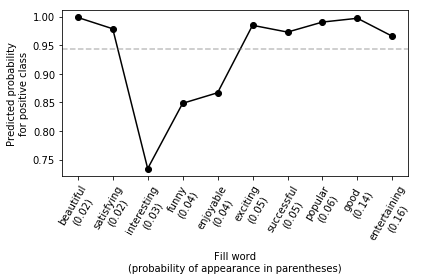

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.gca()
# ax = plt.subplot(111)
plt.plot(v, '-o', color='black')
plt.xticks(range(n), w)
ax.set_xticklabels(labs, rotation=60)
plt.xlabel('Fill word\n(probability of appearance in parentheses)')
plt.ylabel('Predicted probability\nfor positive class')
plt.axhline(0.944, color='gray', alpha=0.5, linestyle='--')
plt.tight_layout()
# fig.subplots_adjust(bottom=0.7)
plt.savefig(oj(out_dir, 'fig_nlp.pdf'))
plt.show()